In [12]:
import numpy as np
import os
import h5py
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import PowerTransformer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA

datadir = '/home/naf999/jupyter-workspace/cse382m/final_project/data/'
figdir  = '/home/naf999/jupyter-workspace/cse382m/final_project/figures_data/'

fname_data = os.path.join(datadir, 'gas_data.hdf5')   

# UPDATED DATA TO BE USED:
# datasets in fname_data: 
#  - data_1point (sample all 14 gas properties at t_formation) (212x14)
#  - data_5point (sample gas properties at 5 times between start of simulation and t_formation) (212x5*14)
#  - data_10point (sample at 10 different times) (212x10*14)
#  - data_20_point (212x20*14)
#  - data_30_point
#  - data_50_point
#  - sink_IDs (212x1)
#  - labels (multiplicity labels) (212x1)

# Return the labels, gas properties (sampled at 1 up to 50 times in simulation), and sink_IDs.
def loadData(fname_data):
    with h5py.File(fname_data, 'r') as f:
        sink_IDs     = f['sink_IDs'][()]      # (212,)
        labels       = f['labels'][()]        # (212,)
        data_1point  = f['data_1point'][()]   # (212, 1x14)
        data_5point  = f['data_5point'][()]   # (212, 5x14)
        data_10point = f['data_10point'][()]  # (212, 10x14)
        data_20point = f['data_20point'][()]  # (212, 20x14)
        data_30point = f['data_30point'][()]  # (212, 30x14)
        data_50point = f['data_50point'][()]  # (212, 50x14)
        
        data = [data_1point, data_5point, data_10point, data_20point, data_30point, data_50point]
        
        # Replace NaN with 0
        for dset in data:
            dset[np.isnan(dset)] = 0.0
            
        # Replace inf with 0 for now.
        for dset in data:
            dset[np.isinf(dset)] = 0.0
            
        n_sinks = len(sink_IDs)
        
    return np.reshape(labels, (n_sinks, 1)), data, np.reshape(sink_IDs, (n_sinks, 1))

def getData(fname_data, num_samples='20'):
    '''
    num_samples = '1', '5', '10', '20', '30', '50'
    '''
    labels, data, sink_IDs = loadData(fname_data)
    y = labels
    if num_samples == '1':
        x = data[0]
    elif num_samples =='5':
        x = data[1]
    elif num_samples == '10':
        x = data[2]
    elif num_samples == '20':
        x = data[3]
    elif num_samples == '30':
        x = data[4]
    else:
        x = data[5]
    return x, y

# Preprocess data and split into train, test datasets.
def preprocessData(x, y):
    pt   = PowerTransformer(method= 'yeo-johnson', standardize= True)
    x_trans = pt.fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x_trans, y, train_size= 0.8)
    return x_train, x_test, np.ravel(y_train), np.ravel(y_test)

def runSVM(x, y, make_fig=True):
    x_train, x_test, y_train, y_test = preprocessData(x, y)
    
    svm_soft = SVC(kernel= 'rbf', C=1.0)
    svm_soft.fit(x_train, y_train)
    y_pred_test = svm_soft.predict(x_test)
    y_pred_train = svm_soft.predict(x_train)
    print("Train data accuracy:", metrics.accuracy_score(y_pred_train, y_train))
    print("Test data accuracy:", metrics.accuracy_score(y_test, y_pred_test))

    pca = PCA(n_components=2)
    reducedX_train = pca.fit_transform(x_train)
    
    if make_fig:
        fig, ax = plt.subplots(1, 2, layout = 'tight', figsize=[10, 5])
        color = ['g', 'b', 'k', 'y']
        for i, j in enumerate(np.unique(y_train)):
            ax[0].scatter(reducedX_train[np.ravel(y_train == j),0], 
                          reducedX_train[np.ravel(y_train == j),1], 
                          c = color[i], label = np.int32(j))
            ax[1].scatter(reducedX_train[np.ravel(y_pred_train == j),0], 
                          reducedX_train[np.ravel(y_pred_train == j),1], 
                          c = color[i], label = np.int32(j))

        ax[0].set_title('Reduced train data with label')
        ax[1].set_title('Kernel SVM prediction')
        ax[0].legend()
        ax[1].legend()
        plt.show()

Number of snapshots used = 1
Train data accuracy: 0.5384615384615384
Test data accuracy: 0.3953488372093023


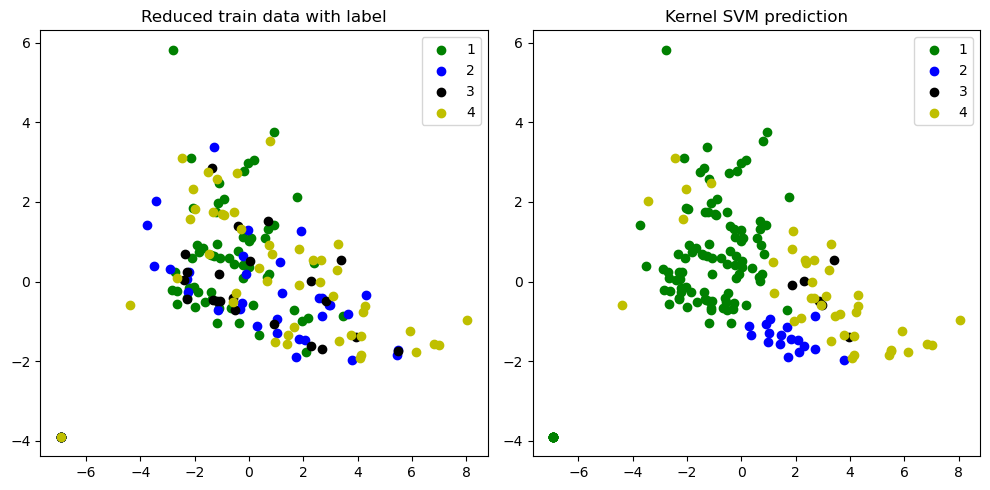

Number of snapshots used = 5
Train data accuracy: 0.650887573964497
Test data accuracy: 0.4186046511627907


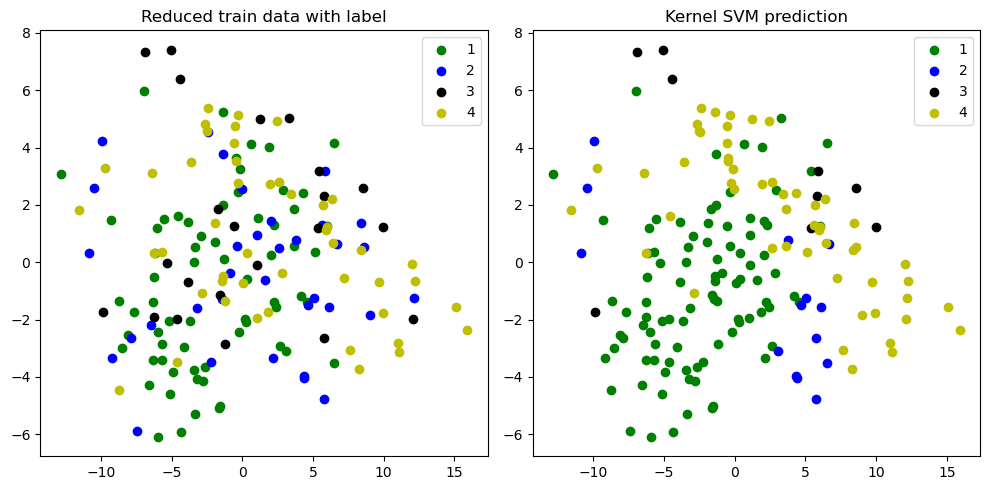

Number of snapshots used = 10
Train data accuracy: 0.6331360946745562
Test data accuracy: 0.5348837209302325


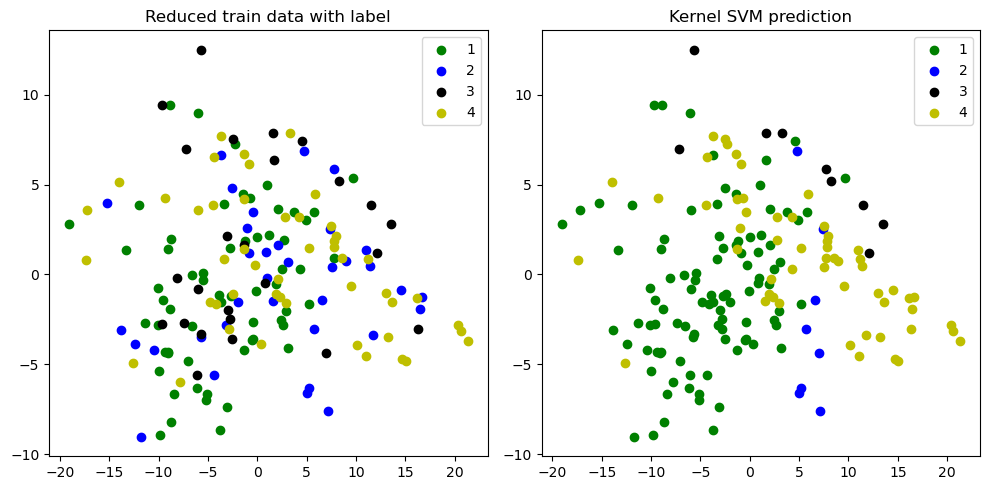

Number of snapshots used = 20
Train data accuracy: 0.6863905325443787
Test data accuracy: 0.32558139534883723


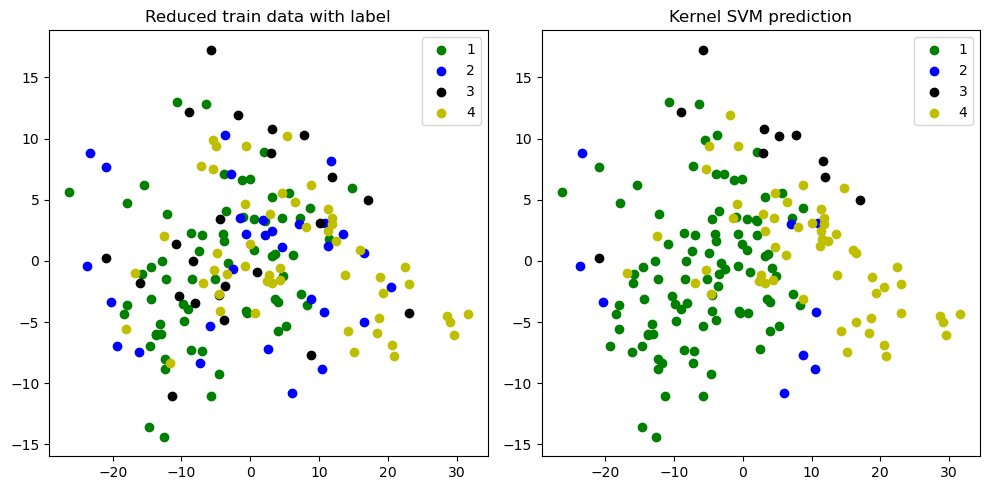

Number of snapshots used = 30
Train data accuracy: 0.6804733727810651
Test data accuracy: 0.4186046511627907


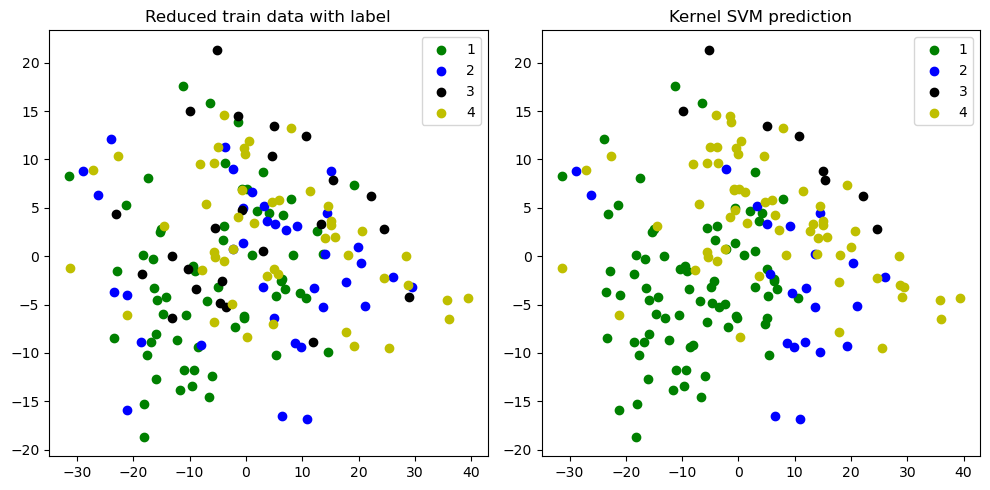

Number of snapshots used = 50
Train data accuracy: 0.6863905325443787
Test data accuracy: 0.5116279069767442


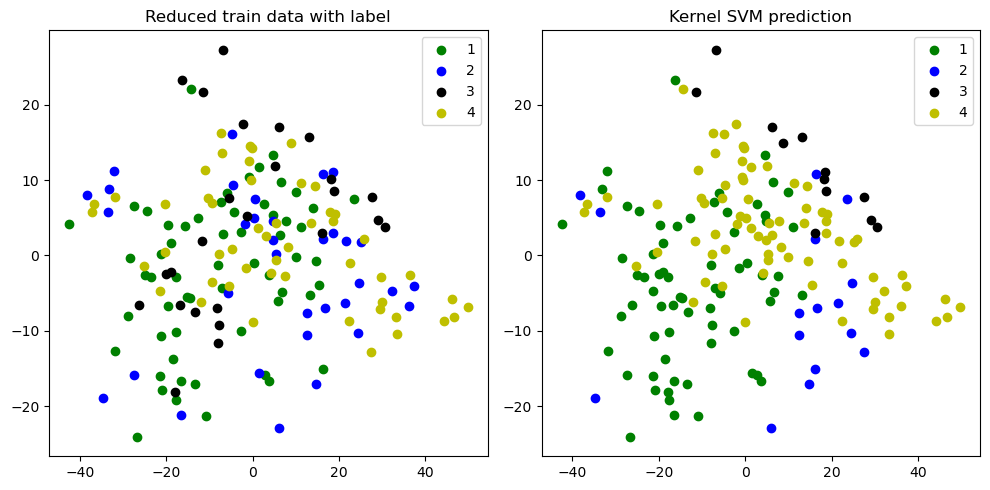

In [13]:
for num_samples in ['1', '5', '10', '20', '30', '50']:
    print('Number of snapshots used = {0:s}'.format(num_samples))
    x, y = getData(fname_data, num_samples=num_samples)
    runSVM(x, y, make_fig=True)